In [ ]:
import pandas as pd
import os
import re
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
from sklearn.preprocessing import minmax_scale
import IPython.display as ipd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **samples to show the waveforms and spectrograms:**

In [ ]:

directory = '/content/drive/MyDrive/Dysarthria_demo'
data = pd.read_csv("/content/drive/MyDrive/Dysarthria_demo/data.csv")
data['filename'] = data['filename'].apply(lambda x: os.path.join(directory,x))

data['label'] = data['is_dysarthria'].apply(lambda x: 1 if x == 'dysarthria' else 0)
data

,is_dysarthria,gender,filename,label
0,non_dysarthria,female,/content/drive/MyDrive/Dysarthria_demo/torgo_d...,0
1,non_dysarthria,female,/content/drive/MyDrive/Dysarthria_demo/torgo_d...,0
2,non_dysarthria,female,/content/drive/MyDrive/Dysarthria_demo/torgo_d...,0
3,non_dysarthria,female,/content/drive/MyDrive/Dysarthria_demo/torgo_d...,0
4,non_dysarthria,female,/content/drive/MyDrive/Dysarthria_demo/torgo_d...,0
...,...,...,...,...
1995,dysarthria,male,/content/drive/MyDrive/Dysarthria_demo/torgo_d...,1
1996,dysarthria,male,/content/drive/MyDrive/Dysarthria_demo/torgo_d...,1
1997,dysarthria,male,/content/drive/MyDrive/Dysarthria_demo/torgo_d...,1
1998,dysarthria,male,/content/drive/MyDrive/Dysarthria_demo/torgo_d...,1


# **Functions for showning spectrogrm and waveplots**

In [ ]:
# Function to plot waveform Samples
def show_waveplot(audio_path,label,gender):
    x , sr = librosa.load(audio_path)
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(x, sr=sr)
    plt.title(f"Waveplot: of Class: {label}, Gender: {gender}")

# Function to plot spectrogram
def show_spectrogram(audio_path,label,gender):
    x , sr = librosa.load(audio_path)
    X = librosa.stft(x)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(10,4))
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz',cmap='plasma')
    plt.colorbar()
    plt.title(f"Spectrogram of Class: {label}, Gender: {gender}")

# Function to plot Mel-Spectrogram
def show_melspectro(audio_path,label,gender):
    plt.figure(figsize=(10, 4))
    plt.title(f'Mel Spectro of Class: {label}, Gender: {gender}')
    x , sr = librosa.load(audio_path)
    melspectro = librosa.feature.melspectrogram(y=x, sr=sr)
    librosa.display.specshow(melspectro, sr=sr, x_axis='time',cmap='plasma')
    plt.show()

# function to plot Mfccs
def show_mfccs(audio_path,label,gender):
    plt.figure(figsize=(10, 4))
    plt.title(f'MFCC of Class: {label}, Gender: {gender}')
    x , sr = librosa.load(audio_path)
    mfccs = librosa.feature.mfcc(y=x, sr=sr)
    librosa.display.specshow(mfccs, sr=sr, x_axis='time',cmap='plasma')
    plt.show()

# **Fetching Audio Samples: Gender and Dysarthric Case:**

In [ ]:
data.sample(frac=1).reset_index(drop=True,inplace=True)
male_dysarthric = data[(data['gender']=='male') & (data['is_dysarthria']=='dysarthria')].sample(1)
female_dysarthric = data[(data['gender']=='female') & (data['is_dysarthria']=='dysarthria')].sample(1)
male_ndysarthric = data[(data['gender']=='male') & (data['is_dysarthria']=='non_dysarthria')].sample(1)
female_ndysarthric = data[(data['gender']=='female') & (data['is_dysarthria']=='non_dysarthria')].sample(1)

## **Male Dysarthric voice:**

In [ ]:
ipd.Audio(male_dysarthric.iloc[0].filename)

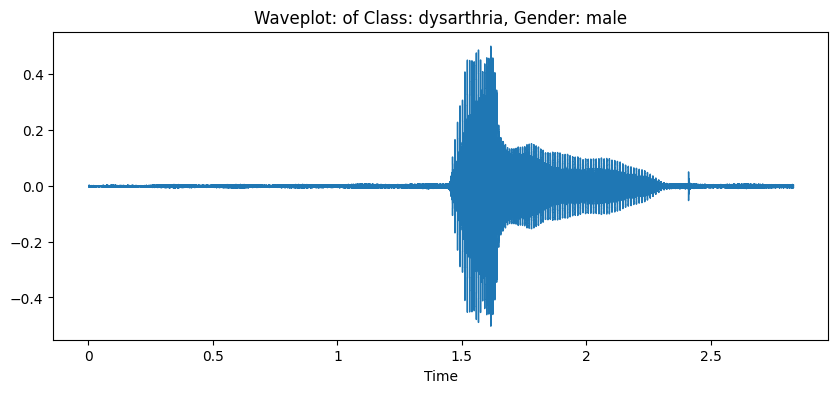

In [ ]:
show_waveplot(male_dysarthric.iloc[0].filename, male_dysarthric.iloc[0].is_dysarthria, male_dysarthric.iloc[0].gender)

# **Female dysarthric voice:**

In [ ]:
ipd.Audio(female_dysarthric.iloc[0].filename)

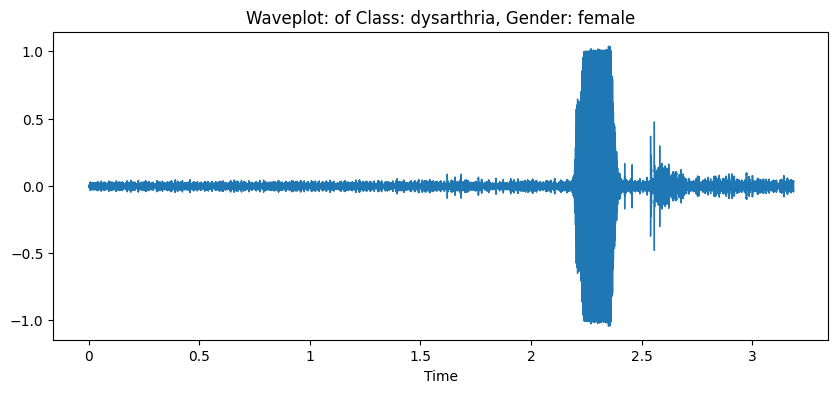

In [ ]:
show_waveplot(female_dysarthric.iloc[0].filename, female_dysarthric.iloc[0].is_dysarthria, female_dysarthric.iloc[0].gender)

# **Spectrogram of dysarthic voice:**

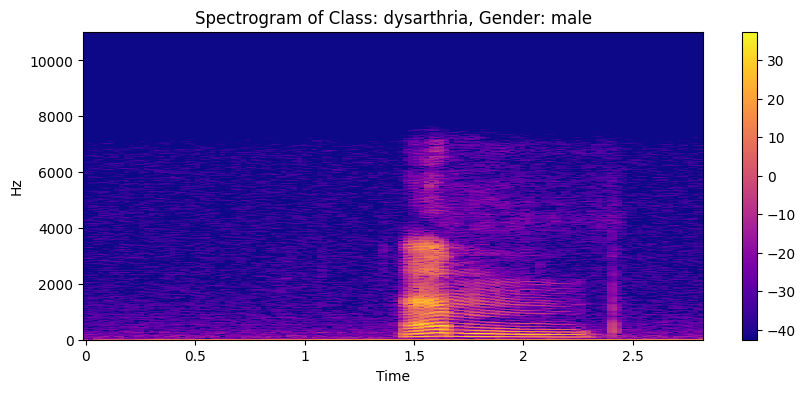

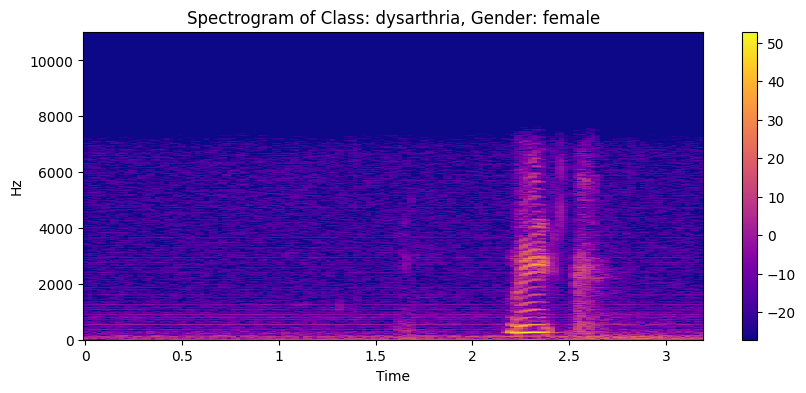

In [ ]:
show_spectrogram(male_dysarthric.iloc[0].filename, male_dysarthric.iloc[0].is_dysarthria, male_dysarthric.iloc[0].gender)
show_spectrogram(female_dysarthric.iloc[0].filename, female_dysarthric.iloc[0].is_dysarthria, female_dysarthric.iloc[0].gender)

## **MFCC Feature Extraction for Random forest and GMM:**
## We performed this experiment on entire torgo data set

In [ ]:
import pandas as pd
import librosa
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, recall_score
import numpy as np
import torch


In [ ]:
# def getting_file_name(file_name):
#   file_split=file_name.split('_')
#   folder_name='not'
#   if "C" in file_split[0]:
#     folder_name='not'
#   else:
#     folder_name='Yes'
#   return folder_name


In [ ]:
def getting_folder_name(folder_path):
  file_split=folder_path.split('/')
  ff=file_split[-1].split('_')
  if ff[0]=='dysarthria':
    folder_name='dysarthria'
    return folder_name
  else:
    folder_name='non_dysarthria'
    return folder_name

In [ ]:
mfcc_final=[]
root_folder='/content/drive/MyDrive/Dysarthria_demo/torgo_data'
# folder='/content/drive/MyDrive/Dysartrhia_dataset/torgo_data'
label=[]
lab_val=0
for folder in os.listdir(root_folder):
  curr_folder=os.path.join(root_folder,folder)
  print("curr",curr_folder)
  # print(len(os.listdir(curr_folder)))
  for file in os.listdir(curr_folder):
    # print("file",file,os.path.join(curr_folder,file))
    # print(len(os.listdir(curr_folder)))


    try:
      x,sr=librosa.load(os.path.join(curr_folder,file))
      mfccs = librosa.feature.mfcc(y=x, sr=sr)
      row, col = mfccs.shape
      mfcc_t=mfccs.T
      print(np.shape(mfcc_t))
      row_t,col_t=mfcc_t.shape
      # print("tras",row_t,col_t)
      # print(mfccs[0].shape)

      folder_name=getting_folder_name(curr_folder)
      # print("folder name",folder_name)

      if folder_name=='dysarthria':
        for k in range(row_t):
          label.append(1)
          mfcc_final.append(mfcc_t[k])
      else:
        for k in range(row_t):
          label.append(0)
          mfcc_final.append(mfcc_t[k])
    except:
      print("probelmatic file",file)



curr /content/drive/MyDrive/Dysarthria_demo/torgo_data/non_dysarthria_female
(91, 20)
(86, 20)
(87, 20)
(75, 20)
(88, 20)
(107, 20)
(90, 20)
(183, 20)
(148, 20)
(100, 20)
(128, 20)
(261, 20)
(91, 20)
(172, 20)
(122, 20)
(281, 20)
(87, 20)
(127, 20)
(129, 20)
(87, 20)
(105, 20)
(145, 20)
(127, 20)
(253, 20)
(176, 20)
(91, 20)
(85, 20)
(97, 20)
(185, 20)
(86, 20)
(285, 20)
(80, 20)
(130, 20)
(127, 20)
(202, 20)
(121, 20)
(85, 20)
(92, 20)
(186, 20)
(147, 20)
(72, 20)
(548, 20)
(142, 20)
(93, 20)
(93, 20)
(79, 20)
(81, 20)
(92, 20)
(154, 20)
(89, 20)
(95, 20)
(202, 20)
(133, 20)
(85, 20)
(154, 20)
(138, 20)
(106, 20)
(82, 20)
(224, 20)
(179, 20)
(209, 20)
(356, 20)
(232, 20)
(196, 20)
(162, 20)
(76, 20)
(81, 20)
(88, 20)
(153, 20)
(229, 20)
(205, 20)
(85, 20)
(141, 20)
(88, 20)
(159, 20)
(267, 20)
(148, 20)
(79, 20)
(97, 20)
(83, 20)
(184, 20)
(89, 20)
(131, 20)
(89, 20)
(85, 20)
(94, 20)
(104, 20)
(280, 20)
(145, 20)
(147, 20)
(104, 20)
(96, 20)
(143, 20)
(86, 20)
(86, 20)
(136, 20)
(164

/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=946
  warnings.warn(


(1091, 20)
(125, 20)
(157, 20)
(139, 20)
(134, 20)
(684, 20)
(108, 20)
(99, 20)
(127, 20)
(140, 20)
(105, 20)
(161, 20)
(263, 20)
(108, 20)
(321, 20)
(119, 20)
(496, 20)
(140, 20)
(575, 20)
(114, 20)
(83, 20)
(164, 20)
(411, 20)
(490, 20)
(104, 20)
(98, 20)
(227, 20)
(459, 20)
(151, 20)
(109, 20)
(104, 20)
(146, 20)
(110, 20)
(597, 20)
(130, 20)
(161, 20)
(129, 20)
(151, 20)
(442, 20)
(148, 20)
(500, 20)
(143, 20)
(146, 20)
(120, 20)
(784, 20)
(135, 20)
(145, 20)
(109, 20)
(113, 20)
(196, 20)
(145, 20)
(140, 20)
(89, 20)
(132, 20)
(115, 20)
(500, 20)
(139, 20)
(164, 20)
(81, 20)
(118, 20)
(750, 20)
(91, 20)
(158, 20)
(99, 20)
(123, 20)
(430, 20)
(625, 20)
(142, 20)
(107, 20)
(335, 20)
(171, 20)
(107, 20)
(2, 20)
(1, 20)
(108, 20)
(1, 20)
(92, 20)
(2, 20)


/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=581
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=214
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=185
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=583
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=209
  warnings.warn(


(2, 20)
(1, 20)
(1, 20)
(113, 20)
(365, 20)
(345, 20)
(162, 20)
(197, 20)
(126, 20)
curr /content/drive/MyDrive/Dysarthria_demo/torgo_data/dysarthria_female
(48, 20)
(38, 20)
(57, 20)
(207, 20)
(424, 20)
(64, 20)
(34, 20)
(73, 20)
(192, 20)
(90, 20)
(80, 20)
(57, 20)
(68, 20)
(82, 20)
(98, 20)
(60, 20)
(60, 20)
(92, 20)
(441, 20)
(55, 20)
(61, 20)
(406, 20)
(414, 20)
(215, 20)
(89, 20)
(49, 20)
(230, 20)
(104, 20)
(535, 20)
(69, 20)
(203, 20)
(59, 20)
(43, 20)
(123, 20)
(51, 20)
(57, 20)
(63, 20)
(92, 20)
(300, 20)
(46, 20)
(261, 20)
(66, 20)
(80, 20)
(79, 20)
(356, 20)
(53, 20)
(49, 20)
(82, 20)
(91, 20)
(99, 20)
(86, 20)
(90, 20)
(52, 20)
(81, 20)
(46, 20)
(44, 20)
(41, 20)
(59, 20)
(361, 20)
(90, 20)
(395, 20)
(57, 20)
(44, 20)
(39, 20)
(320, 20)
(57, 20)
(67, 20)
(48, 20)
(126, 20)
(82, 20)
(54, 20)
(41, 20)
(69, 20)
(52, 20)
(182, 20)
(55, 20)
(64, 20)
(59, 20)
(101, 20)
(42, 20)
(58, 20)
(31, 20)
(310, 20)
(24, 20)
(44, 20)
(49, 20)
(51, 20)
(77, 20)
(56, 20)
(62, 20)
(48, 20)
(9

<ipython-input-14-841f6b14f4e8>:16: UserWarning: PySoundFile failed. Trying audioread instead.
  x,sr=librosa.load(os.path.join(curr_folder,file))
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


(188, 20)
(71, 20)
(57, 20)
(110, 20)
(40, 20)
(269, 20)
(24, 20)
(79, 20)
(29, 20)
(53, 20)
(88, 20)
(44, 20)
(136, 20)
(212, 20)
(277, 20)
(46, 20)
(120, 20)
(88, 20)
(47, 20)
(97, 20)
(42, 20)
(62, 20)
(106, 20)
(57, 20)
(94, 20)
(67, 20)
(39, 20)
(106, 20)
(60, 20)
(110, 20)
(45, 20)
(49, 20)
(122, 20)
(55, 20)
(53, 20)
(36, 20)
(246, 20)
(51, 20)
(54, 20)
(48, 20)
(106, 20)
(57, 20)
(41, 20)
(152, 20)
(160, 20)
(99, 20)
(66, 20)
(59, 20)
(36, 20)
(57, 20)
(208, 20)
(58, 20)
(62, 20)
(80, 20)
(72, 20)
(75, 20)
(51, 20)
(77, 20)
(75, 20)
(180, 20)
(86, 20)
(136, 20)
(81, 20)
(99, 20)
(95, 20)
(81, 20)
(83, 20)
(401, 20)
(97, 20)
(136, 20)
(95, 20)
(63, 20)
(77, 20)
(62, 20)
(94, 20)
(88, 20)
(66, 20)
(204, 20)
(106, 20)
(55, 20)
(237, 20)
(73, 20)
(168, 20)
(121, 20)
(81, 20)
(70, 20)
(59, 20)
(75, 20)
(117, 20)
(150, 20)
(58, 20)
(60, 20)
(221, 20)
(49, 20)
(72, 20)
(188, 20)
(75, 20)
(253, 20)
(95, 20)
(73, 20)
(139, 20)
(64, 20)
(99, 20)
(123, 20)
(75, 20)
(100, 20)
(195, 20)
(22

In [ ]:
print(len(mfcc_final),len(label))
X=np.array(mfcc_final)
Y=np.array(label)

270215 270215


# **Random forest classifer:**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

xtrain,xtest,ytrain,ytest=train_test_split(X,Y,test_size=0.30)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf =  RandomForestClassifier()
clf.fit(xtrain,ytrain)


RandomForestClassifier()

In [ ]:
ypred=clf.predict(xtest)
score=accuracy_score(ytest, ypred)
print("accuracy",score)

accuracy 0.9384321223709369


#**Section to run if you have already a trained model**

In [ ]:
# # dont run this cell
# import pickle

# filename = "/content/drive/MyDrive/Dysarthria_demo/random_forest.pickle"

# # save model
# pickle.dump(clf, open(filename, "wb"))

# # load model
# loaded_model = pickle.load(open(filename, "rb"))


# **Gaussian Mixture Model:**

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
n_components = 16
gmm = GaussianMixture(n_components=n_components, random_state=42)

# Fit the model to the training data
gmm.fit(xtrain)

# Predict labels on the test set
y_pred = gmm.predict(xtest)

# Evaluate accuracy
accuracy = accuracy_score(ytest, y_pred)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test Accuracy: 8.44%


#**Section to run if you have already a trained model**

In [ ]:
# import pickle

# filename = "/content/drive/MyDrive/Dysarthria_demo/gmm.pickle"

# # save model
# pickle.dump(gmm, open(filename, "wb"))

# # load model
# loaded_model = pickle.load(open(filename, "rb"))

# **MFCC feature extraction for SVM and DNN :**  
## We performe this experiment on a subset of torgo datset

In [ ]:
mfcc_final=[]
root_folder='/content/drive/MyDrive/Dysarthria_demo/torgo_data_sample_1'
# folder='/content/drive/MyDrive/Dysartrhia_dataset/torgo_data'
label=[]
lab_val=0
for folder in os.listdir(root_folder):
  curr_folder=os.path.join(root_folder,folder)
  print("curr",curr_folder)
  # print(len(os.listdir(curr_folder)))
  for file in os.listdir(curr_folder):
    # print("file",file,os.path.join(curr_folder,file))
    # print(len(os.listdir(curr_folder)))


    try:
      x,sr=librosa.load(os.path.join(curr_folder,file))
      mfccs = librosa.feature.mfcc(y=x, sr=sr)
      row, col = mfccs.shape
      mfcc_t=mfccs.T
      print(np.shape(mfcc_t))
      row_t,col_t=mfcc_t.shape
      # print("tras",row_t,col_t)
      # print(mfccs[0].shape)

      folder_name=getting_folder_name(curr_folder)
      print("folder name",folder_name)

      if folder_name=='dysarthria':
        for k in range(row_t):
          label.append(1)
          mfcc_final.append(mfcc_t[k])
      else:
        for k in range(row_t):
          label.append(0)
          mfcc_final.append(mfcc_t[k])
    except:
      print("probelmatic file",file)

curr /content/drive/MyDrive/Dysarthria_demo/torgo_data_sample_1/non_dysarthria_female
(143, 20)
folder name non_dysarthria
(304, 20)
folder name non_dysarthria
(281, 20)
folder name non_dysarthria
(145, 20)
folder name non_dysarthria
(136, 20)
folder name non_dysarthria
(164, 20)
folder name non_dysarthria
(133, 20)
folder name non_dysarthria
(267, 20)
folder name non_dysarthria
(138, 20)
folder name non_dysarthria
(229, 20)
folder name non_dysarthria
(135, 20)
folder name non_dysarthria
(178, 20)
folder name non_dysarthria
(147, 20)
folder name non_dysarthria
(128, 20)
folder name non_dysarthria
(135, 20)
folder name non_dysarthria
(284, 20)
folder name non_dysarthria
(129, 20)
folder name non_dysarthria
(130, 20)
folder name non_dysarthria
(141, 20)
folder name non_dysarthria
(127, 20)
folder name non_dysarthria
(122, 20)
folder name non_dysarthria
(261, 20)
folder name non_dysarthria
(147, 20)
folder name non_dysarthria
(121, 20)
folder name non_dysarthria
(143, 20)
folder name non_

In [ ]:
print(len(mfcc_final),len(label))
x=np.array(mfcc_final)
y=np.array(label)

16727 16727


# **SVM classifier:**

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.15)

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
svm_clf =  SVC(kernel='rbf')
svm_clf.fit(x_train,y_train)


SVC()

In [ ]:
y_pred=svm_clf.predict(x_test)
score=accuracy_score(y_test, y_pred)
print("accuracy",score)

accuracy 0.9868525896414343


#**Loading and saving the model:**

In [ ]:
import pickle

filename = "/content/drive/MyDrive/Dysarthria_demo/svm_clf.pickle"

# save model
pickle.dump(svm_clf, open(filename, "wb"))

# load model
loaded_model = pickle.load(open(filename, "rb"))

# **Deep Neural network:**

In [ ]:
import torch.nn as nn
import torch.optim as optim

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
X_train_tensor = torch.from_numpy(x_train).to(device)
y_train_tensor = torch.from_numpy(y_train).to(device)
X_test_tensor = torch.from_numpy(x_test).to(device)
y_test_tensor = torch.from_numpy(y_test).to(device)

In [ ]:
# a,b=X_tensor.shape
# c=y_tensor.shape
# print(a,b,c)


In [ ]:
class DNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        # print(x.shape)
        x = self.fc2(x)
        # print(x.shape)
        return x
print(X_train_tensor.shape[0],y_train_tensor.shape[0])
model = DNN(X_train_tensor.shape[1], 128, y_train_tensor.shape[0]).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(10):
    for i in range(X_train_tensor.shape[0]):
        optimizer.zero_grad()
        # print(X_tensor[i],X_tensor[i].shape)
        outputs = model(X_train_tensor[i])
        loss = criterion(outputs, y_train_tensor[i])

        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}, Loss: {loss.item():.4f}')



14217 14217
Epoch 1, Loss: -0.0000
Epoch 2, Loss: -0.0000
Epoch 3, Loss: -0.0000
Epoch 4, Loss: -0.0000
Epoch 5, Loss: -0.0000
Epoch 6, Loss: -0.0000
Epoch 7, Loss: -0.0000
Epoch 8, Loss: -0.0000
Epoch 9, Loss: -0.0000
Epoch 10, Loss: -0.0000


In [ ]:
# Set the model to evaluation mode
model.eval()

with torch.no_grad():
    new_data_tensor = X_test_tensor[10]
    output = model(new_data_tensor)
    _, predicted_class = torch.max(output, 0)

print(f'Predicted Class: {predicted_class.item()}')

Predicted Class: 0


In [ ]:
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0

with torch.no_grad():
    for i in range(X_test_tensor.shape[0]):
        outputs = model(X_test_tensor[i])
        _, predicted = torch.max(outputs.data, 0)
        total += 1
        correct += (predicted == y_test_tensor[i]).sum().item()

accuracy = correct / total
print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test Accuracy: 95.94%
